<img src="https://d1u5p3l4wpay3k.cloudfront.net/lolesports_gamepedia_en/thumb/5/5b/Worlds_2018.png/1200px-Worlds_2018.png" />
<h1 style="text-align:center"> Analyzing League of Legends Champions and Match Statistics   </h1>
<h6 style="text-align:center"> Calvin Holman | Daniel Briggs | Christina Tobin </h6>

<h3> Introduction </h3>

League of a online game...blah blah blah...explain how the game is played.

Our goal is blah

<h3> Getting Started with the Data </h3>

Importing libraries and talking about where we get data from

In [1]:
!pip install statsmodels
!pip install scipy
!pip install lxml
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import re

from itertools import chain
from itertools import combinations

from sklearn import linear_model
import statsmodels.formula.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


<h3> Preprocessing the Data </h3>

Parsing data 

In [2]:
# Notes and stuff:

# Can we predict games?
#  -Use regular season data. Maybe compare each laner individually when looking at players?

# What makes a player good? -need to come up with a heuristic, -> Winrate.
#  -What is/are the most important values in a player? Is it kda or something less known like cs/m
#  -Look at similarities between people with a higher rating based on our heuristic

# Role importance?
#  -Does a single role have more influence over a team's win. For example do teams with a better mid laner win more often.
#  -Need the rating system first

# DATA:

# Player data from Worlds -> playersWorlds

# Champion data from Worlds play-ins -> champs

# Player data from regular season by region -> reg
#   reg[0] --> North America (NA)
#   reg[1] --> Europe (EU)
#   reg[2] --> China (LPL)
#   reg[3] --> Korea (LCK)
#   reg[4] --> Taiwan (LMS)
#   reg[5] --> Vietnam (VCS)

# Match data from regular season by region -> matchReg
#   matchReg[0] --> North America (NA)
#   matchReg[1] --> Europe (EU)
#   matchReg[2] --> China (LPL)
#   matchReg[3] --> Korea (LCK)
#   matchReg[4] --> Taiwan (LMS)
#   matchReg[5] --> Vietnam (VCS)

# Link of what league is for noobs (christina)
# https://na.leagueoflegends.com/en/game-info/get-started/

# Picture of 2018 Worlds Icon
# https://d1u5p3l4wpay3k.cloudfront.net/lolesports_gamepedia_en/thumb/5/5b/Worlds_2018.png/1200px-Worlds_2018.png

In [7]:


# GET requests for all of the different datasets we will need.

# Gather tournament data on all 90 players
r = requests.get("https://lol.gamepedia.com/2018_Season_World_Championship/Main_Event/Player_Statistics")

# Regular season data from North America
r2 = requests.get("https://lol.gamepedia.com/NA_LCS/2018_Season/Summer_Season/Player_Statistics")

# Regular Season data from EU
r3 = requests.get("https://lol.gamepedia.com/EU_LCS/2018_Season/Summer_Season/Player_Statistics")

# Regular Season data from the LPL
r4 = requests.get("https://lol.gamepedia.com/LPL/2018_Season/Summer_Season/Player_Statistics")

# Regular Season data from the LCK
r5 = requests.get("https://lol.gamepedia.com/LCK/2018_Season/Summer_Season/Player_Statistics")

# Regular Season data from the LMS
r6 = requests.get("https://lol.gamepedia.com/LMS/2018_Season/Summer_Season/Player_Statistics")

# Regular Season data from the VCS
r7 = requests.get("https://lol.gamepedia.com/VCS/2018_Season/Summer_Season/Player_Statistics")

# Champion data from play-ins
r8 = requests.get("https://lol.gamepedia.com/2018_Season_World_Championship/Main_Event/Champion_Statistics")

In [4]:
# Match data from each region

# The website changed the way they encoded their data, so the parser for the match data doesn't work anymore, but luckily we
# saved all of the data to a csv file which we will be using instead. But this is how we got the data in the first place from
# their website.

# Match data from North America
r9 = requests.get("https://lol.gamepedia.com/NA_LCS/2018_Season/Summer_Season")

# Match data from Europe
r10 = requests.get("https://lol.gamepedia.com/EU_LCS/2018_Season/Summer_Season")

# Regular Season data from the LPL
r11 = requests.get("https://lol.gamepedia.com/LPL/2018_Season/Summer_Season")

# Regular Season data from the LCK
r12 = requests.get("https://lol.gamepedia.com/LCK/2018_Season/Summer_Season")

# Regular Season data from the LMS
r13 = requests.get("https://lol.gamepedia.com/LMS/2018_Season/Summer_Season")

# Regular Season data from the VCS
r14 = requests.get("https://lol.gamepedia.com/VCS/2018_Season/Summer_Season")

ls = []
matchReg = []
j = 0

# Parse with lxml
ls.append(BeautifulSoup(r9.text, "lxml"))
ls.append(BeautifulSoup(r10.text, "lxml"))
ls.append(BeautifulSoup(r11.text, "lxml"))
ls.append(BeautifulSoup(r12.text, "lxml"))
ls.append(BeautifulSoup(r13.text, "lxml"))
ls.append(BeautifulSoup(r14.text, "lxml"))

# Number of teams for each region
numTeams = [10,10,7,10,8,8]

for bs in ls:
    
    # Different parsing rules for the LPL
    if j==2:
        bs = BeautifulSoup(r11.text, "lxml")

        l = str(bs).split("title=\"Points\"")[1:]

        arr = []  # final array for the dataframe

        # Loop for east and west region
        for t in range(0,2):
            l[t] = l[t].split("title=\"")[1:]

            l2 = []     # Remove unnecessary rows
            l2 = [s for s in l[t] if "std.png" not in s]
            l[t] = l2

            l[t][numTeams[2]-1] = l[t][numTeams[2]-1].split("</div>")[0]

            # Get each team's data
            for x in range(0,numTeams[2]):
                l[t][x] = l[t][x].split("align=\"center")
                l2 = []
                l2.append(l[t][x][0].split("\">")[0])

                # Different parsing rules for each region
                if (t==2):
                    l2.append(l[t][x][5][2:9])
                else:
                    l2.append(l[t][x][3][2:9])

                # add to our final array
                arr.append(l2)

        # Create the dataframe
        matchReg.append(pd.DataFrame(np.array(arr).reshape(len(arr),2), columns = ['Team', 'Record']))
    
    # Need to parse differently for the EU_LCS page
    elif j==1:
        
        l = str(bs).split("Overall")[1].split("</tbody>")[0].split("</th></tr>")[1:-1]
        
        for h in range(0,len(l)):
            l[h] = l[h].split("style=\"background-color:")
            
            # Team name  
            l[h][0] = l[h][0].split("title=")[1].split("\"><img alt")[0][1:]
            
            # Get match data
            for g in range(1,numTeams[j]+1):
                tmpStr = l[h][g][6:]
                tmpStr = 'blank' if tmpStr[0] == 'A' else tmpStr[0:5]
                
                l[h][g] = tmpStr
            
            l[h] = l[h][0:-1]
            
        teams = ["Teams"]
        for t in l:
            teams.append(t[0])
            
        # Create the dataframe
        matchReg.append(pd.DataFrame(np.array(l).reshape(len(l),len(l[0])), columns = teams))

        # Replace our spacer values with NaN to standardize it
        matchReg[j] = matchReg[j].replace("blank",np.nan)
        
    #lms and vcs 
    elif j==4 or j==5:
        l = str(bs).split("Overall")[1].split("</tbody>")[0].split("</th></tr>")[1:-1]
        
        for h in range(0,len(l)):
            l[h] = l[h].split("style=\"background-color:")
            
            # Team name  
            l[h][0] = l[h][0].split("title=")[1].split("\"><img alt")[0][1:]
            
            l2 = []
            l2 = [s for s in l[h] if "display" not in s]
            l[h] = l2
            
            # Get match data
            for g in range(1,numTeams[j]+1):
                tmpStr = l[h][g][6:]
                tmpStr = 'blank' if tmpStr[0] == 'A' else tmpStr[1:6]
                
                l[h][g] = tmpStr
            
            l[h] = l[h][0:-1]
        
            teams = ["Teams"]
        for t in l:
            teams.append(t[0])
            
        # Create the dataframe
        matchReg.append(pd.DataFrame(np.array(l).reshape(len(l),len(l[0])), columns = teams))

        # Replace our spacer values with NaN to standardize it
        matchReg[j] = matchReg[j].replace("blank",np.nan)
      
    # Default parser -> Works for NA_LCS and LCK
    else:
        l = str(bs).split("plainlinks crossbox")[1].split("title=")[1:]

        # Get all of the teams
        for x in range(0,numTeams[j]):
            l[x] = l[x][1:]
            l[x] = l[x].split("\"><img alt")[0]

        # Get all team names as the first element
        l[0:numTeams[j]] = [','.join(l[0:numTeams[j]])]
        l[0] = l[0].split(",")

        # Get match data for each team
        for t in range(1,numTeams[0]+1):
            l[t] = l[t].split("<span class=\"crossbox-match-link")[:-1]

            # Get the score for how well each team did
            for x in range(0,len(l[t])):
                l[t][x] = l[t][x][-5:]

            # Insert the team name at the beginning of the row
            l[t].insert(0,l[0][t-1])

        # Cut off unnecessary rows in the array
        l = l[:numTeams[j]+1]

        # Insert spacing because you can't play yourself
        for t in range(1,numTeams[j]+1):
            l[t].insert(t,'blank')
            l[t] = l[t][:numTeams[j]+1]

        # Insert new column
        l[0].insert(0,'Teams')

        # Create the dataframe
        matchReg.append(pd.DataFrame(np.array(l[1:]).reshape(len(l)-1,len(l[0])), columns = l[0]))

        # Replace our spacer values with NaN to standardize it
        matchReg[j] = matchReg[j].replace("blank",np.nan)
    
    j = j+1


<h3> Reading the Data </h3>

Storing data into the dataframe

In [8]:
# Since we stored the data into csv files, we can just read them in with pandas.
matchReg = []
matchReg.append(pd.read_csv("naMatchdat.csv").drop('Unnamed: 0',axis=1))
matchReg.append(pd.read_csv("EUMatchdat.csv").drop('Unnamed: 0',axis=1))
matchReg.append(pd.read_csv("LPLMatchdat.csv").drop('Unnamed: 0',axis=1))
matchReg.append(pd.read_csv("LCKMatchdat.csv").drop('Unnamed: 0',axis=1))
matchReg.append(pd.read_csv("LMSMatchdat.csv").drop('Unnamed: 0',axis=1))
matchReg.append(pd.read_csv("VCSMatchdat.csv").drop('Unnamed: 0',axis=1))

matchReg[0]['Region'] = 2
matchReg[1]['Region'] = 4
matchReg[2]['Region'] = 6
matchReg[3]['Region'] = 5
matchReg[4]['Region'] = 3
matchReg[5]['Region'] = 1

# Some data manipulation to make our lives easier down the road.
# We will set the winner to be either 0 or 100 to increase our weights.
for x in range(0,len(matchReg)):
    matchReg[x]['Winner'] = matchReg[x]['Winner']*100
    t = matchReg[x].replace(0,5)
    t = t.replace(100,0)
    matchReg[x] = t.replace(5,100)
    
# Combine each region's data into one master dataframe
masterMatch = pd.concat(matchReg).reset_index().drop('index',axis=1)

<h3> Tidying and Modifying the Data </h3>

In [9]:
# Player data for the Worlds Tournament

# Parse with lxml
bs = BeautifulSoup(r.text, "lxml")

# split to get all 90 players individually
players = str(bs).split("std.png/45px")[1:]

# split to get each column
for x in range (0,len(players)):
    players[x] = players[x].split("</td>")
    
    # Get the team name
    players[x][0] = players[x][0][1:].split("_std.png")[0][:-4]
    
    # Get the player's name
    players[x][1] = players[x][1].split("title=\"")[1].split("\">")[0]
    
    for y in range (2,19):
        if y!=17:
            players[x][y] = players[x][y].split("center\">")[1].split("\n")[0]
    
    players[x][17] = players[x][17][-17]

# Convert into data frame with appropriate columns
playersWorlds = pd.DataFrame(np.array(players).reshape(90,20), columns = ['Team','Player','Games','Wins','Losses','Winrate','Kills','Deaths','Assists','KDA','CS','CSPM','Gold','GPM','Kill Participation','Kill Share','Gold Share','Champions Played','19','20'])

# Drop unnecessary columns
playersWorlds = playersWorlds.drop(['19','20'],axis=1)

# Get numeric data
playersWorlds['Games'] = playersWorlds['Games'].str.extract('(\d+)', expand=False)
playersWorlds['Gold'] = playersWorlds['Gold'].str[:-1]
playersWorlds['Kill Participation'] = playersWorlds['Kill Participation'].str[:-1]
playersWorlds['Kill Share'] = playersWorlds['Kill Share'].str[:-1]
playersWorlds['Gold Share'] = playersWorlds['Gold Share'].str[:-1]

#playersWorlds

In [10]:
# Regular season data for each region
# We also took precautions and decided to save this to a csv file once we combined all of the data together from each region.

ls = []
reg = []

# Parse with lxml
ls.append(BeautifulSoup(r2.text, "lxml"))
ls.append(BeautifulSoup(r3.text, "lxml"))
ls.append(BeautifulSoup(r4.text, "lxml"))
ls.append(BeautifulSoup(r5.text, "lxml"))
ls.append(BeautifulSoup(r6.text, "lxml"))
ls.append(BeautifulSoup(r7.text, "lxml"))

j = 0
for bs in ls:
    
    # split to get all the players individually
    players = str(bs).split("std.png/45px")[1:]

    # split to get each column
    for x in range (0,len(players)):
        players[x] = players[x].split("</td>")

        # Get the player's name
        players[x][1] = players[x][1].split("title=\"")[1].split("\"")[0]

        # Get the team name
        players[x][0] = players[x][0][1:].split("_std.png")[0][:-4]

        for y in range (2,17):
            players[x][y] = players[x][y].split("center\">")[1].split('\n')[0]
            
        players[x][17] = players[x][17][-18:-16]

    # Convert into data frame
    reg.append(pd.DataFrame(np.array(players).reshape(len(players),len(players[0])), columns = ['Team','Player','Games','Wins','Losses','Winrate','Kills','Deaths','Assists','KDA','CS','CSPM','Gold','GPM','Kill Participation','Kill Share','Gold Share','Champions Played','19','20']))

    # Drop unnecessary columns
    reg[j] = reg[j].drop(['19','20'],axis=1)
    
    # Get just numeric data
    reg[j]['Games'] = reg[j]['Games'].str.extract('(\d+)', expand=False)
    reg[j]['Champions Played'] = reg[j]['Champions Played'].str.extract('(\d+)', expand=False)
    reg[j]['Gold'] = reg[j]['Gold'].str[:-1]
    reg[j]['Gold Share'] = reg[j]['Gold Share'].str[:-1]
    reg[j]['Kill Participation'] = reg[j]['Kill Participation'].str[:-1]
    reg[j]['Kill Share'] = reg[j]['Kill Share'].str[:-1]
        
    j = j+1

# reg contains regular season data by region
# reg[0] --> North America (NA)
# reg[1] --> Europe (EU)
# reg[2] --> China (LPL)
# reg[3] --> Korea (LCK)
# reg[4] --> Taiwan (LMS)
# reg[5] --> Vietnam (VCS)

# Convert data into numeric form
for t in reg:
    k=0
    for col in t.columns:
        if k>1 and k<18:
            t[col] = pd.to_numeric(t[col])
        k=k+1
        
# Sort the tables based on 'Games' and 'Player' to standardize the view
reg[0] = reg[0].sort_values(['Games','Player'],ascending=[False,True])
reg[1] = reg[1].sort_values(['Games','Player'],ascending=[False,True])
reg[2] = reg[2].sort_values(['Games','Player'],ascending=[False,True])
reg[3] = reg[3].sort_values(['Games','Player'],ascending=[False,True])
reg[4] = reg[4].sort_values(['Games','Player'],ascending=[False,True])
reg[5] = reg[5].sort_values(['Games','Player'],ascending=[False,True])

# Get Position data for players from the regular season.
# Position can be Top, JG, Mid, ADC, or Supp.

# NOTE: This was hard-coded because the values won't change and it was more feasible than downloading 30 separate tables 
#       and just looking at a single column for each one.

#pos = ['Top','ADC','Mid','JG','Top','Supp','Mid','Supp','ADC','Top','ADC','JG','JG','Mid','Top','Supp','Mid','Top','JG','JG','Mid','Mid','Supp','ADC','ADC','Top','Supp','ADC','Top','Top','Supp','ADC','Mid','Top','Supp','ADC','JG','Supp','Supp','JG','Mid','JG','Mid','JG','Top','Mid','ADC','Supp','ADC','ADC','JG','JG','Supp','Mid','JG','Mid','ADC','Top','Supp','JG','Supp','JG','ADC','Supp','Mid','JG','Top']
pos = ['Supp', 'Mid', 'ADC', 'JG', 'Top', 'JG', 'Top', 'Top', 'Mid',
       'Supp', 'Mid', 'JG', 'Top', 'ADC', 'ADC', 'ADC', 'Supp', 'Supp',
       'JG', 'ADC', 'ADC', 'Mid', 'Mid', 'Top', 'Top', 'Top', 'Supp',
       'Supp', 'Mid', 'Mid', 'Top', 'ADC', 'JG', 'Top', 'JG', 'ADC',
       'Supp', 'Supp', 'JG', 'Mid', 'JG', 'Supp', 'JG', 'Mid', 'Top',
       'Mid', 'Supp', 'ADC', 'ADC', 'ADC', 'JG', 'JG', 'Supp', 'Mid',
       'Mid', 'JG', 'Top', 'ADC', 'Supp', 'Supp', 'Mid', 'JG', 'JG', 'ADC',
       'Supp', 'JG', 'Top']
reg[0]['Position'] = pos

#pos1 = ['Mid','Mid','Supp','Supp','Top','Supp','JG','ADC','Top','Top','JG','ADC','Mid','ADC','Mid','JG','Supp','ADC','JG','Mid','Mid','Mid','ADC','Mid','ADC','JG','Mid','Top','Supp','Supp','Top','Supp','Supp','Top','Supp','Top','ADC','Top','JG','JG','Top','JG','ADC','Supp','ADC','Top','Mid','JG','JG','ADC','JG','JG','ADC','ADC','Mid','Supp']
#pos1 = ['JG','ADC','Supp','Mid','Supp','Top','Supp','JG','ADC','Top','Top','Mid','Mid','ADC','JG','Mid','Mid','Mid','ADC','JG','Mid','Mid','ADC','Mid','ADC','JG','Top','Supp','Top','JG','Supp','JG','Top','JG','Top','Top','Supp','Supp','Supp','ADC','Top','Supp','ADC','ADC','Supp','Top','Mid','JG','ADC','JG','JG','ADC','JG','ADC','Mid','Supp']
pos1 = ['JG', 'ADC', 'Top', 'ADC', 'Supp', 'JG', 'Mid', 'Mid', 'Mid', 'ADC',
       'Supp', 'Top', 'Supp', 'Top', 'Top', 'Mid', 'Mid', 'JG', 'Mid',
       'JG', 'Mid', 'ADC', 'ADC', 'Supp', 'Supp', 'ADC', 'JG', 'JG', 'JG',
       'Mid', 'Supp', 'Top', 'Top', 'Supp', 'Top', 'Mid', 'Supp', 'Top',
       'ADC', 'Supp', 'Top', 'JG', 'ADC', 'ADC', 'Supp', 'Top', 'Mid',
       'JG', 'JG', 'JG', 'ADC', 'JG', 'ADC', 'ADC', 'Supp', 'Mid']
reg[1]['Position'] = pos1

#pos2 = ['Supp','ADC','JG','Supp','Top','Mid','Top','Mid','Supp','JG','JG','ADC','Mid','Top','Top','Mid','Mid','JG','ADC','Supp','Supp','ADC','ADC','Top','Supp','ADC','Supp','Supp','Top','Top','ADC','Mid','Mid','Mid','Top','Supp','ADC','Mid','JG','JG','Top','Top','JG','Mid','Supp','Supp','Supp','Top','ADC','Supp','JG','Mid','Top','JG','ADC','Mid','ADC','Mid','ADC','Supp','Mid','JG','JG','ADC','ADC','JG','Top','JG','ADC','JG','Mid','Top','JG','JG','Top','ADC','Mid','JG','JG','Supp','JG','Top','JG','ADC','ADC','Top','Mid','JG','JG','Mid','ADC','ADC','Top','Mid','Top','ADC','Supp','Supp','ADC','JG','Supp','Mid']
pos2 = ['JG','ADC','Supp','Mid','Top','JG','Mid','Top','Top','Supp','ADC','Supp','Mid','Supp','Top','ADC','JG','JG','Mid','Supp','Mid','Supp','Top','Mid','ADC','Supp','ADC','Supp','Top','Mid','ADC','Top','ADC','JG','Supp','Top','Supp','Mid','ADC','Supp','Top','Mid','Top','JG','Supp','ADC','JG','Mid','Top','JG','ADC','JG','JG','Supp','Top','ADC','Mid','JG','Top','Mid','JG','ADC','ADC','Mid','ADC','Mid','JG','Supp','Top','JG','Top','Mid','JG','Top','Mid','JG','Top','ADC','ADC','JG','ADC','JG','Mid','JG','Supp','JG','ADC','Mid','Supp','ADC','Top','JG','JG','Top','ADC','Mid','ADC','ADC','JG','Supp','Mid','Supp']
reg[2]['Position'] = pos2

#pos3 = ['Supp','Mid','Top','ADC','Supp','Top','Supp','Mid','Supp','Top','ADC','Top','ADC','Mid','Supp','Supp','Top','Mid','JG','Mid','ADC','Supp','Top','JG','Supp','Mid','JG','Mid','Top','Top','Top','Mid','ADC','Top','ADC','Supp','ADC','JG','ADC','ADC','JG','ADC','JG','Mid','Supp','JG','JG','Mid','JG','JG','JG','JG','ADC','JG','JG','Mid','Supp','JG','ADC','JG','Supp','ADC','JG','Mid','ADC','Mid','Top','Top','ADC','Supp','Top']
pos3 = ['Top', 'Mid', 'Supp', 'Supp', 'Mid', 'Top', 'Supp', 'ADC', 'JG',
       'Top', 'ADC', 'Supp', 'Mid', 'ADC', 'Top', 'Mid', 'Top', 'Top',
       'ADC', 'Supp', 'Supp', 'Supp', 'ADC', 'Mid', 'Top', 'Mid', 'ADC',
       'Mid', 'Mid', 'Supp', 'Top', 'JG', 'JG', 'ADC', 'JG', 'Top', 'JG',
       'ADC', 'Supp', 'ADC', 'Top', 'Supp', 'JG', 'JG', 'JG', 'ADC', 'Mid',
       'JG', 'JG', 'Mid', 'Mid', 'JG', 'JG', 'ADC', 'JG', 'Supp', 'Mid',
       'JG', 'JG', 'Supp', 'JG', 'ADC', 'ADC', 'JG', 'Mid', 'ADC', 'Supp',
       'Top', 'ADC', 'Top', 'Top']
reg[3]['Position'] = pos3

#pos4 = ['Supp','Top','Mid','JG','Supp','Top','Top','JG','Supp','Supp','ADC','Supp','Mid','ADC','ADC','Mid','JG','Mid','Top','Supp','ADC','ADC','Mid','ADC','JG','Mid','ADC','Top','Supp','Supp','ADC','Top','JG','Mid','Top','JG','Mid','JG','ADC','Top','JG','Top','JG','ADC','JG','Mid','Top','JG','JG','Top','JG','Top','Supp','ADC','JG','Supp','Supp','Supp','JG','JG']
pos4 = ['Supp', 'Top', 'JG', 'Mid', 'Top', 'Supp', 'ADC', 'Mid', 'ADC',
       'Top', 'JG', 'Supp', 'Supp', 'JG', 'Mid', 'ADC', 'Supp', 'ADC',
       'Supp', 'ADC', 'Mid', 'Top', 'ADC', 'Mid', 'JG', 'Mid', 'Top',
       'ADC', 'Supp', 'Supp', 'Top', 'ADC', 'Top', 'JG', 'Mid', 'Mid',
       'JG', 'JG', 'ADC', 'Top', 'JG', 'Top', 'ADC', 'JG', 'JG', 'Mid',
       'Top', 'JG', 'JG', 'JG', 'Top', 'ADC', 'Top', 'Supp', 'JG', 'Supp',
       'Supp', 'Supp', 'JG', 'JG']
reg[4]['Position'] = pos4

#pos5 = ['Top','ADC','Supp','Mid','ADC','Mid','Top','Top','Mid','Supp','Mid','JG','JG','JG','ADC','Mid','ADC','Top','Mid','Top','Supp','JG','ADC','Top','ADC','Supp','JG','ADC','Supp','JG','JG','Supp','Supp','Mid','Top','ADC','ADC','JG','Supp','Mid','Top','JG','Supp','Mid','Top','Top','Supp','Mid','JG','ADC','Supp','Supp','Supp','JG','Mid','Supp','JG','Top','JG','Mid']
pos5 = ['ADC', 'Mid', 'Supp', 'Top', 'ADC', 'Top', 'JG', 'Mid', 'Supp',
       'ADC', 'JG', 'Top', 'Mid', 'Mid', 'JG', 'Mid', 'ADC', 'Top', 'Supp',
       'Mid', 'Top', 'JG', 'Top', 'ADC', 'Supp', 'ADC', 'JG', 'ADC',
       'Supp', 'JG', 'Supp', 'JG', 'Supp', 'Top', 'Mid', 'ADC', 'ADC',
       'JG', 'Supp', 'Mid', 'Top', 'JG', 'Supp', 'Mid', 'Top', 'Top',
       'Supp', 'Mid', 'JG', 'ADC', 'Supp', 'Supp', 'Supp', 'Mid', 'JG',
       'Supp', 'JG', 'Top', 'JG', 'Mid']
reg[5]['Position'] = pos5

# Combine regular season player data from each region into a master table
masterReg = pd.concat(reg).sort_values(['Games','Player'],ascending=[False,True]).reset_index().drop('index',axis=1)
#masterReg.to_csv('masterReg.csv')  # Save the data for use later on so we don't have to parse every time.

In [11]:
# Read in the table since we saved it already.
masterReg = pd.read_csv("masterReg.csv").drop("Unnamed: 0",axis=1)

# List of all column vars
vars = ['KDA', 'GPM', 'Kill Share', 'Kill Participation', 'Kills', 'Deaths', 'Assists','Gold', 'Gold Share', 'CS', 'CSPM', 'Champions Played']

# Create tables based on player position for our machine learning model.
top = masterReg[masterReg['Position']=='Top']
jg = masterReg[masterReg['Position']=='JG']
mid = masterReg[masterReg['Position']=='Mid']
adc = masterReg[masterReg['Position']=='ADC']
supp = masterReg[masterReg['Position']=='Supp']

In [12]:
# Champion data from worlds

# Parse with lxml
bs = BeautifulSoup(r8.text, "lxml")

# split to get all champions individually
tmp = str(bs).split("Square.png/40px")[1:]

# split to get each column
for x in range (0,len(tmp)):
    
    tmp[x] = tmp[x].split("</td>")
    
    # Get the Champion's name
    tmp[x][0] = tmp[x][0].split("title=\"")[1].split("\"")[0]
    
    # Get other column data
    for y in range (1,19):
        if y==5 or y==6:
            tmp[x][y] = tmp[x][y].split("</b>")[0]
        if y != 7:
            tmp[x][y] = tmp[x][y].split("center\">")[1].split("\n")[0]
    
    t = tmp[x][7].split("_blank\">") 
    tmp[x][7] = 0 if len(t)==1 else t[1][:2]

# Convert into data frame with appropriate columns
champs = pd.DataFrame(np.array(tmp).reshape(len(tmp),len(tmp[0])), columns = ['Champion','Bans','Games','Wins','Losses','Winrate','PB','By','Kills','Deaths','Assists','KDA','CS','CSPM','Gold','GPM','Kill Participation','Kill Share','Gold Share', '20'])

# Drop unnecessary columns
champs = champs.drop('20',axis=1)

# Get just numeric data
champs['By'] = champs['By'].str.extract('(\d+)', expand=False)
champs['Gold'] = champs['Gold'].str[:-1]
champs['Kill Participation'] = champs['Kill Participation'].str[:-1]
champs['Kill Share'] = champs['Kill Share'].str[:-1]
champs['Gold Share'] = champs['Gold Share'].str[:-1]
champs['Winrate'] = champs['Winrate'].str[3:]
champs['PB'] = champs['PB'].str[3:]

# Making data NaN for champs banned, but not played. Might want to drop these entries entirely though.
pat = re.compile('-1')
for col in champs.columns:
    champs[col] = champs[col].replace(pat, np.nan)

# Save the data as a csv so we don't have to parse it every time.
champs.to_csv("champs.csv")

<h3> Analyzing Champion Data </h3>

Now that all our data is ready, we can start analyzing champion data to see if we can predict win rate with champion statistics like KDA (Kill Death Assist Ratio). League of Legends also allows players to ban certain champions at the start of every game. It would be interesting to see if we can predict whether a champion will be banned with the same champion statistics, so we will analyze that as well.

Let's start with analyzing the ban rate. First let's pick some of the most important statistics in our data, and perform a T-test between each statistic and the ban rate and see if there is a possible linear relationship. We will also plot the points on a chart to verify if a linear relationship exists or not.

We will start with KDA. KDA is measured as $\frac{Kills + \frac{Assists}{3}}{Deaths}$ so it rewards kills and assists with the appropriate weights. It is recognized as a relatively good indicator of how well a player does in the game, so we would expect a champion that typically gets a high KDA to be banned a lot, as the high KDA means the champion is likely to do well.

'P Value from T-test for KDA:'

array(0.83060075)

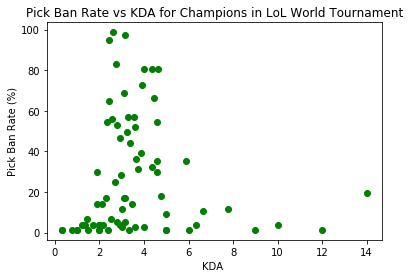

In [13]:
champs['PB'] = champs['PB'].astype('float')
champs['Winrate'] = champs['Winrate'].astype('float')
champs['Kill_Participation'] = champs['Kill Participation'].astype('float')
champs['Gold_Share'] = champs['Gold Share'].astype('float')
champs['Kill_Share'] = champs['Kill Share'].astype('float')
champs['KDA'] = champs['KDA'].astype('float')
champs['CSPM'] = champs['CSPM'].astype('float')
champs['GPM'] = champs['GPM'].astype('float')
model = sm.ols(formula='PB ~ KDA', data =champs).fit()
display("P Value from T-test for KDA:",model.t_test('KDA = 0').pvalue)

plt.title("Pick Ban Rate vs KDA for Champions in LoL World Tournament")
plt.xlabel("KDA ")
plt.ylabel("Pick Ban Rate (%)")
plt.plot(champs['KDA'],champs['PB'],'go')

Surprisingly, our T test showed that KDA is not linearly related to Ban Rate, since our P value of 0.83 is not less than our threshold of 0.05. The chart also doesn't show any sort of linear relationship. This means the players don't consider a champions KDA when picking to ban them. 

Let's try analyzing another kill related statistic in Kill Participation. A high kill participation (calculated as $\frac{Champion Kills}{Total Team Kills}$) indicates a player had a lot of his team kills, and thus had a large impact on the game. Players should be more likely to ban high impact champions so this should be linearly related to ban rate.

'P Value from T-test for Kill Participation:'

array(0.74472394)

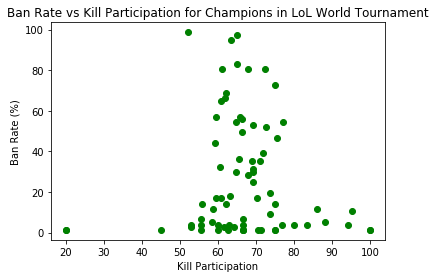

In [14]:
model = sm.ols(formula='PB ~ Kill_Participation', data = champs).fit()
display("P Value from T-test for Kill Participation:",model.t_test('Kill_Participation = 0').pvalue)

plt.title("Ban Rate vs Kill Participation for Champions in LoL World Tournament")
plt.xlabel("Kill Participation")
plt.ylabel("Ban Rate (%)")
plt.plot(champs['Kill_Participation'],champs['PB'],'go')



Surprisingly that's not related to ban rate either as we can see from the chart and high p-value, so it seems like players don't consider a champions potential to have a large amount of kills or assists at all when banning champions. 

Lets analyze some of the other key statistics in our data, like CSPM (number of minions killed per minute) and Gold per Minute, as we expect these also are likely to be related to ban rate since they indicate how quickly a champion can accumulate gold and minion kills.

'P Value from T-test for CSPM:'

array(0.42535271)

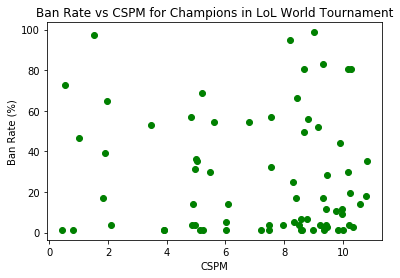

In [15]:
model = sm.ols(formula='PB ~ CSPM', data = champs).fit()
display("P Value from T-test for CSPM:",model.t_test('CSPM = 0').pvalue)

plt.title("Ban Rate vs CSPM for Champions in LoL World Tournament")
plt.xlabel("CSPM")
plt.ylabel("Ban Rate (%)")
plt.plot(champs['CSPM'],champs['PB'],'go')

Intercept    31.959159
GPM          -0.013965
dtype: float64

'P Value from T-test for GPM:'

array(0.77087128)

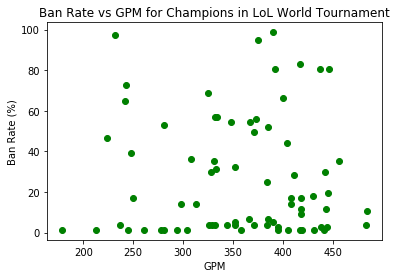

In [16]:
model = sm.ols(formula='PB ~ GPM', data = champs).fit()
display(model.params)
display("P Value from T-test for GPM:",model.t_test('GPM = 0').pvalue)

plt.title("Ban Rate vs GPM for Champions in LoL World Tournament")
plt.xlabel("GPM")
plt.ylabel("Ban Rate (%)")
plt.plot(champs['GPM'],champs['PB'],'go')

Surprisingly, neither CSPM or GPM are linearly related to ban rate either, as indicated by their high p values and the shape of their plots when compared to ban rate. This indicates that players don't consider champions ability to farm gold when choosing who to ban. 

Now that we have exhausted most of the variables we thought were linearly related to ban rate, let's try analyzing the win rate of champions and see if that is linearly related to ban rate.

'P Value from T-test for GPM:'

array(0.02955141)

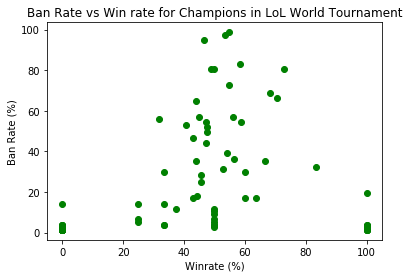

In [27]:
model = sm.ols(formula='PB ~ Winrate', data = champs).fit()
display("P Value from T-test for GPM:",model.t_test('Winrate = 0').pvalue)

plt.title("Ban Rate vs Win rate for Champions in LoL World Tournament")
plt.xlabel("Winrate (%)")
plt.ylabel("Ban Rate (%)")
plt.plot(champs['Winrate'],champs['PB'],'go')

Finally something that is related to ban rate! It seems players choose to ban champions based on how often players with those champions win.

Let's explore this relationship a little more. We can get the coefficients from our model and generate some predicted values for a champions ban-rate given their win rate.

Intercept    16.181643
Winrate       0.245335
dtype: float64

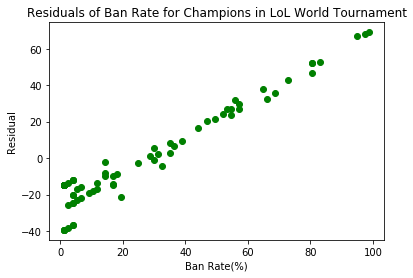

In [36]:
display(model.params)

champs['predicted_ban_rate'] = champs['Winrate'] * .245335 + 16.181643
champs['residuals_ban_rate'] = champs['PB'] - champs['predicted_ban_rate']

plt.title("Residuals of Ban Rate for Champions in LoL World Tournament")
plt.xlabel("Ban Rate(%)")
plt.ylabel("Residual")
plt.plot(champs['PB'],champs['residuals_ban_rate'],'go')

Obviously our residual plot raises a lot of concerns. A residual plot is supposed to be randomly distributed around 0, but ours is a line that increases as ban rate increases. Unfortunately, since all the other important variables were shown to be non-related with ban rate, we can't include any other variables to fix this. It seems like it is very difficult to predict what kinds of champions are banned. 

However, we can still see if we can predict winning percentage based on champion statistics. We will start by analyzing the relationship between winning percentage and KDA. It is reasonable to assume that a champion with a high winning percentage would have a high KDA, so let's test that theory.

'P Value from T-test:'

array(3.03152389e-09)

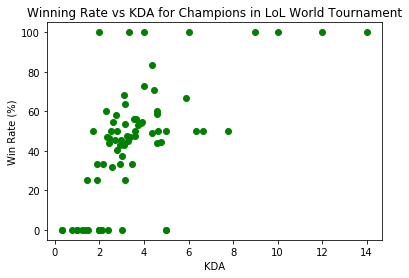

In [18]:
model = sm.ols(formula='Winrate ~ KDA', data = champs).fit()
display("P Value from T-test:",model.t_test('KDA = 0').pvalue)

plt.title("Winning Rate vs KDA for Champions in LoL World Tournament")
plt.xlabel("KDA")
plt.ylabel("Win Rate (%)")
plt.plot(champs['KDA'],champs['Winrate'],'go')

It appears winning rate is linear related to KDA for League of Legends champions. This means a champion with a high KDA will win more games on average, which makes sense. Now let's examine the gold based statistics like CSPM and GPM.

'P Value from T-test:'

array(0.22898347)

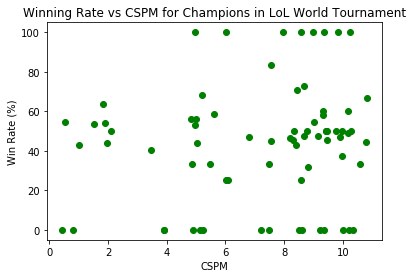

In [19]:
model = sm.ols(formula='Winrate ~ CSPM', data = champs).fit()
display("P Value from T-test:",model.t_test('CSPM = 0').pvalue)

plt.title("Winning Rate vs CSPM for Champions in LoL World Tournament")
plt.xlabel("CSPM")
plt.ylabel("Win Rate (%)")
plt.plot(champs['CSPM'],champs['Winrate'],'go')

'P Value from T-test:'

array(0.00135858)

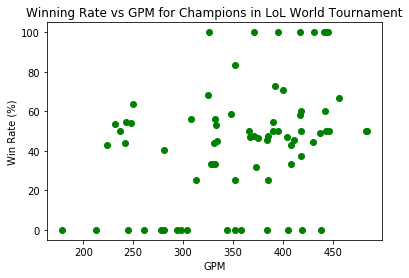

In [20]:
model = sm.ols(formula='Winrate ~ GPM', data = champs).fit()
display("P Value from T-test:",model.t_test('GPM = 0').pvalue)

plt.title("Winning Rate vs GPM for Champions in LoL World Tournament")
plt.xlabel("GPM")
plt.ylabel("Win Rate (%)")
plt.plot(champs['GPM'],champs['Winrate'],'go')

While CSPM doesn't seem to be linearly related to win rate, as indicated by the high p-value, we can see that GPM does seem to be linearly related which makes sense since more gold leads to better gear which can lead to more kills.

One reason CSPM might not be linearly related to win rate is some champions are supposed to have a low CSPM, like support champions, since they want their AD to take all of the CS. This would lead to good support champions having a low CSPM, but a high win rate. 

Since win rate is linearly related to KDA and GPM, let's create a model with both variables in it.

In [21]:
model = sm.ols(formula='Winrate ~ GPM+   KDA', data = champs).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Winrate   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     23.20
Date:                Sun, 09 Dec 2018   Prob (F-statistic):           1.77e-08
Time:                        18:19:26   Log-Likelihood:                -336.91
No. Observations:                  74   AIC:                             679.8
Df Residuals:                      71   BIC:                             686.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7508     14.338      0.262      0.794     -24.839      32.340
GPM            0.0391      0.044      0.894      0.374      -0.048       0.126
KDA            7.2517      1.309      5.541      0.000       4.642       9.861
==============================================================================
Omnibus:                        1.677   Durbin-Watson:                   1.644
Prob(Omnibus):                  0.432   Jarque-Bera (JB):                1.031
Skew:                           0.122   Prob(JB):                        0.597
Kurtosis:                       3.524   Cond. No.                     1.92e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Unfortunately, it seems GPM is not significant in predicting winning percentage when it is included in a model with KDA, despite it being individually significant in predicted winning percentage. We will simply not use GPM as a predictor in our model due to this, leaving KDA as our only predictor.

Let's get the coefficients for the model with KDA as the only predictor and generate the predicted winning percentages and residuals.

Intercept    15.771156
KDA           7.801409
dtype: float64

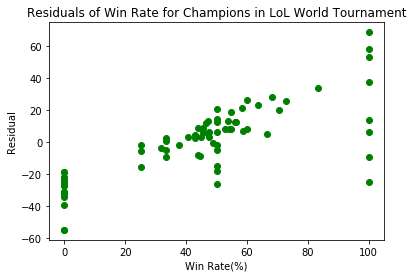

In [40]:
model = sm.ols(formula='Winrate ~ KDA', data = champs).fit()
display(model.params)

champs['predicted_win_rate'] = champs['KDA'] * 7.801409 + 15.771156
champs['residuals_win_rate'] = champs['Winrate'] - champs['predicted_win_rate']

plt.title("Residuals of Win Rate for Champions in LoL World Tournament")
plt.xlabel("Win Rate(%)")
plt.ylabel("Residual")
plt.plot(champs['Winrate'],champs['residuals_win_rate'],'go')

Unfortunately we see the same problems with our residual plot as we did with our ban rate residual plot, it is not randomly distributed around 0 and looks like a increasing diagonal line. It seems champion statistics aren't that relevant in win rate, so win rate is probably more related to things like team-composition, strategies, and skill level. While this is dissapointing, it speaks to how League of Legends has a lot of champions that can help win games and how there aren't a lot of "overpowered" champions that ruin the competitive scene

Let's move to analyzing more team related statistics with the regular season data to see if we can predict wins using that data.

<h3> Analyzing Regular Season Match Data </h3>

In [22]:
# The first bit of machine learning we want to do is determine what makes a player good. To do this, we will be using winrate
# as our y value, and all of the different player statistics as our x variables. The results will tell us which of the
# different variables are important and how important each one is individually. 

# First, we separated all of the data into their own positions, because what makes a mid laner good is probably different from
# what makes a support good.

# Next, we have to determine which variables we should be using to figure out their weights, or coefficients. To do this, we
# created a powerset function that returns every possible combination of the variables we can have.

In [23]:
# The code for this function was taken from:
#     https://codereview.stackexchange.com/questions/178225/computing-the-powerset-of-a-list

# Powerset function of a given list
def gen_powerset(l):
    if not l:  # List is empty
        yield []
        return
    for sub_powerset in gen_powerset(l[1:]): # Generate next list
        yield sub_powerset
        yield [l[0]] + sub_powerset

In [ ]:
# Next, we removed outliers from the data that would significantly impact the results. This is due to us using winrate as our
# measure of how good a player is. For example, if we have a substitute player that only played one game, and won, our algorithm
# thinks that he is the best player in the world. To remove outliers, we tested each dataset with at least 'x' games played
# by players to see what the cutoff should be. We don't want to remove more than 10 games, because that would encrouch on the
# regular season starters for some regions, so we looked at 0-10 for each region.

# The code below is linear regression in machine learning for predicitive analysis.

# Source on what linear regression is and why we use it
#  https://towardsdatascience.com/linear-regression-using-python-ce21aa90ade6
  
# Example of basic linear regression
#  https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

# Source on linear regression of multi-variables, which is the type we did
#  https://datatofish.com/multiple-linear-regression-python/

# Source to understand the purpose and basic use of test and training data
#  https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

In [ ]:
# This is an example of how we determined the cutoffs for each position. This was done on the adc table.

# Must have played at least 0-10 games.
for u in range(0,10):
    
    # All of the variables we want to look at
    vars = ['KDA', 'GPM', 'Kill Share', 'Kill Participation', 'Kills', 'Deaths', 'Assists','Gold', 'Gold Share', 'CS', 'CSPM']

    # Must have played at least 'u' games
    tmp = adc[adc['Games'] >= u]

    best = -1    # Keeps track of the best variance
    bestLs = []  # Holds the list of variables for the best variance
    coef = []    # Contains the coefficients for the variables
    
    # Set winrate to be our ranking for the players
    y = tmp['Winrate']

    # Look at every possible combination of variables for the players
    for ps in gen_powerset(vars):
        
        if ps: # Dont include empty list
            
            X = tmp[ps]
            
            # Split data into test and training sets with an 80/20 split, which is standard to minimize overfitting.
            # 80% of the data is used for training and the remaining 20% is used for testing.
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
            
            # Fit the model to the training data
            regr = linear_model.LinearRegression()
            regr.fit(X_train, y_train)

            #numpy array that contains all the predicted values for the input values in the X series.
            y_pred = regr.predict(X_test)

            # Get the variance score between the test data and our prediction. 1 would be a perfect score.
            residuals = r2_score(y_test, y_pred)

            # Keep track of the best score and which variables we used.
            if residuals > best:
                best = residuals
                bestLs = ps
                coef = regr.coef_
                
    print(str(u) + ": " + str(best))

In [ ]:
# From this output, we see that if we look at just players that have played at least 6 games our variance goes all the way
# up to a 93% accuracy. If we used every player, so at least 0 games played, we would have an 89% accuracy. In the end, this
# should help our model be more consistent by removing outliers in the data. We're allowed to do this because it makes sense 
# heuristically, and we still have a sizeable portion of the regular data. This removes the problem of having a person that
# went 1/1 in their games and our algorithm tries to use them as the best player.

# By having 10 be our max we want to cut out, it ensures that we keep starters for each region, as well as players that split
# time like the junglers for Cloud9, Svenskeren and Blaber. The only players we remove are substitutes.

# This shows us that we are still using 86% of the main data, so we aren't cutting out a significant portion.
len(adc[adc['Games']>=6])/len(adc)

In [ ]:
# We repeated this process for each position and came up with the following numbers for minimum games played:
#   top -  7
#   jg -   2
#   mid -  4
#   adc -  6
#   supp - 7

# We adjust the position tables accordingly.
top = top[top['Games']>=7]
jg = jg[jg['Games']>=2]
mid = mid[mid['Games']>=4]
adc = adc[adc['Games']>=6]
supp = supp[supp['Games']>=7]

# The next step is to look at each position and figure out which variables we want to use now that we removed our outliers.

In [ ]:
# TOP MODEL

# Look at the top 20 results
numResults = 20

# Must have played at least 7 games
tmp = top[top['Games'] >= 7]

#These are the possible column variables to be tested in combinations
vars = ['KDA', 'GPM', 'Kill Share', 'Kill Participation', 'Kills', 'Deaths', 'Assists','Gold', 'Gold Share', 'CS', 'CSPM']

best = [-1]*numResults   # Array of top 20 variance scores
bestLs = [-1]*numResults # Array of corresponding variables to each of the variance scores
coef = [[-1]]*numResults # Array of weights associated with each of the variables producing the variance scores

y = tmp['Winrate']

for ps in gen_powerset(vars):
    if ps:
        X = tmp[ps]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        regr = linear_model.LinearRegression()
        regr.fit(X_train, y_train)
        y_pred = regr.predict(X_test)
        residuals = r2_score(y_test, y_pred)

        # Compares and tracks the best variances
        for x in range(0,len(best)):

            if residuals > best[x]:
                best[x] = residuals
                bestLs[x] = ps
                coef[x] = regr.coef_
                break

In [ ]:
# Now lets look at the resulting variance scores
for x in range(0,len(best)):
    print(best[x])

In [ ]:
# We get scores from 94% to 90% in the top 20. Any of these would work for our model, but we will go through and pick
# the one that makes the most sense heuristically with our League knowledge to ensure that the model won't incorrectly
# predict data down the road. 

# This will show us the variance score, what variables it included and what the weights are for them.
for x in range(0,len(coef)):
    print("Var: " + str(best[x]))
    for y in range(0,len(coef[x])):
        print(bestLs[x][y] + ": " + str(coef[x][y]))
        
    print()

In [ ]:
# TEST MODEL


# Look at the top 20 results
numResults = 20

#These are the possible column variables to be tested in combinations
vars = ['KDA', 'GPM', 'Kill Share', 'Kill Participation', 'Kills', 'Deaths', 'Assists','Gold', 'CS', 'CSPM']

best = [-1]*numResults   # Array of top 20 variance scores
bestLs = [-1]*numResults # Array of corresponding variables to each of the variance scores
coef = [[-1]]*numResults # Array of weights associated with each of the variables producing the variance scores

y = mid['Winrate']

for ps in gen_powerset(vars):
    if ps:
        X = mid[ps]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        regr = linear_model.LinearRegression()
        regr.fit(X_train, y_train)
        y_pred = regr.predict(X_test)
        residuals = r2_score(y_test, y_pred)

        # Compares and tracks the best variances
        for x in range(0,len(best)):

            if residuals > best[x]:
                best[x] = residuals
                bestLs[x] = ps
                coef[x] = regr.coef_
                break
                
for x in range(0,len(coef)):
    print("Var: " + str(best[x]))
    for y in range(0,len(coef[x])):
        print(bestLs[x][y] + ": " + str(coef[x][y]))
        
    print()

In [ ]:
# These are the results we came up with for each position.

#  Top
# Var: 0.931949972536
# KDA: 2.09811734882
# GPM: 0.593191309816
# Kill Participation: 0.386431392477
# Kills: -5.46362811076
# Gold: 12.5323771206
# Gold Share: -14.2182616141
# CS: -0.449448292041
# CSPM: 8.51130983888

# For a top laner, it looks like you shouldn't be focusing on kills to let your team get them instead, but KDA is also positive
# so that encourages you to have more assists. Gold is important, which makes sense because gold is used to buy items, which 
# makes you stronger. However, we see that Gold Share is fairly negative, meaning you should be getting gold, but not at the 
# expense of your team's gold.

#  Jungle
# Var: 0.934277194926
# KDA: 0.181164206403
# GPM: 0.735342254784
# Kills: -2.68009575084
# Deaths: -7.25541495648
# Assists: 1.85733953438
# Gold: 7.16660335062
# Gold Share: -14.1978168455
# CS: -0.385377553174
# CSPM: 10.493478078

# Jungle follows roughly the same logic as top: you want assists, not kills, and you don't want to take a large portion of the
# team's gold.

#  Mid
# Var: 0.901898303047
# GPM: 0.0713156133641
# Deaths: -13.0255264467
# Assists: 3.69342852617
# Gold: 19.8616597461
# CS: -0.845745453945
# CSPM: 12.7679155894

# For some reason the algorithm wanted to have use Gold Share and have it be negative, which doesn't really make sense for a mid
# laner, because you normally want them to have a high percentage of the team's gold. I think the reason this happened is because
# of the data itself. Gold Share, no matter of the position, is always going to be around 20% because it's split between 5 people.
# Because we didn't think this would be a good predictor, we excluded it from our results and looked for a different model. This
# is what we came up with, which still works pretty well. It has a focus on Gold, CSPM, and assists, while also punishing deaths.

#  ADC
# Var: 0.933270580443
# KDA: 0.879083138604
# GPM: 1.13044121708
# Kill Share: 1.03542306739
# Kill Participation: -0.335817323575
# Kills: -12.9697993181
# Assists: 4.65262777296
# CS: 0.128173966315
# CSPM: -11.2995505544
# Gold Share: -12.5435852695

# We ran into the same issue with Gold Share when doing the adc data, but without Gold Share included the variance scores dropped
# too low to be used. To rectify this, we just used the top result and decided not to influence the results in any way. The model
# seems to think that kills, gold share, kill participation, and cspm are all negative, which is counter-intuitive for any
# league of legends adc. Normally your job is to get kills, be involved, and get as much gold as you can so that you can carry
# your team by dealing the most damage. Since this doesn't line up with our intuition, we'll see how the results are at the end
# and talk more about this.

#  Supp
# Var: 0.915741666545
# KDA: 0.0316139479741
# GPM: 1.338934096
# Kill Share: -0.145858503846
# Kills: -3.99163808505
# Deaths: -6.05433184202
# Gold Share: -23.0728233467

# For a support, kills should be negative because you don't want to be taking kills/gold away from your team. Again this follows
# roughly the same pattern as top and jungle.

In [ ]:
# Here we will use the weights we got from our machine learning and use them to calculate a player's winrate. We then take
# the calculated value and add it to the corresponding position table.

top['CalculatedWinrate'] = 2.09811734882*top['KDA'] + 0.593191309816*top['GPM'] + 0.386431392477*top['Kill Participation'] + -5.46362811076*top['Kills'] + 12.5323771206*top['Gold'] + -14.2182616141*top['Gold Share'] + -0.449448292041*top['CS'] + 8.51130983888*top['CSPM']
jg['CalculatedWinrate'] = 0.181164206403*jg['KDA'] + 0.735342254784*jg['GPM'] + -2.68009575084*jg['Kills'] + -7.25541495648*jg['Deaths'] + 1.85733953438*jg['Assists'] + 7.16660335062*jg['Gold'] + -14.1978168455*jg['Gold Share'] + -0.385377553174*jg['CS'] + 10.493478078*jg['CSPM']
mid['CalculatedWinrate'] = mid['GPM']*0.0713156133641 + mid['Deaths']*-13.0255264467 + mid['Gold']*19.8616597461 + mid['CS']*-0.845745453945 + mid['CSPM']*12.7679155894 + mid['Assists']*3.69342852617
adc['CalculatedWinrate'] = 1.13044121708*adc['GPM'] + 1.03542306739*adc['Kill Share'] + -0.335817323575*adc['Kill Participation'] + -12.9697993181*adc['Kills'] + 4.65262777296*adc['Assists'] + 0.128173966315*adc['CS'] + -11.2995505544*adc['CSPM'] + -12.5435852695*adc['Gold Share']
supp['CalculatedWinrate'] = 1.338934096*supp['GPM'] + -0.145858503846*supp['Kill Share'] + -3.99163808505*supp['Kills'] + -6.05433184202*supp['Deaths'] + -23.0728233467*supp['Gold Share']


In [ ]:
# Now we can use machine learning to predict games. First we need to calculate the difference in the calculated winrate
# for each position and save them as variables. These will be the independent variables for our ML and the dependent variable
# will be which team won, a value either 0 or 100.

teams = {}                # Dictionary ('Team' -> [topDiff, jgDiff,...])
nadd = [[],[],[],[],[]]   # Contains new columns to be added to masterMatch

# Go through each game we have data saved for.
for index,row in masterMatch.iterrows():
    
    x1 = [] # Team 0 data
    x2 = [] # Team 1 data
    
    # If we haven't seen this team yet, add it to the dictionary
    if not row['Team 0'] in teams:
        tmp = []
        tmp.append(top[top['Team']==row['Team 0']])
        tmp.append(jg[jg['Team']==row['Team 0']])
        tmp.append(mid[mid['Team']==row['Team 0']])
        tmp.append(adc[adc['Team']==row['Team 0']])
        tmp.append(supp[supp['Team']==row['Team 0']])
        
        for x in tmp:
            if len(x) == 1: # If there's only 1 player at that position, add them in
                x1.append(x['CalculatedWinrate'])
            else:
                x1.append(x['CalculatedWinrate'].mean())  # If there are multiple players, we take the average
                
        # Save the team data in the dictionary for use later on
        teams[row['Team 0']] = x1
        
    else:
        x1 = teams[row['Team 0']]
    
    # Repeat the process for the next team
    if not row['Team 1'] in teams:
        tmp = []
        tmp.append(top[top['Team']==row['Team 1']])
        tmp.append(jg[jg['Team']==row['Team 1']])
        tmp.append(mid[mid['Team']==row['Team 1']])
        tmp.append(adc[adc['Team']==row['Team 1']])
        tmp.append(supp[supp['Team']==row['Team 1']])
        
        for x in tmp:
            if len(x) == 1:
                x2.append(x['CalculatedWinrate'])
            else:
                x2.append(x['CalculatedWinrate'].mean())
                
        teams[row['Team 1']] = x2
    
    else:
        x2 = teams[row['Team 1']]
       
    # Calculate the difference for each lane
    for x in range(0,5):
        nadd[x].append(float(x1[x]) - float(x2[x]))
    
# Update masterMatch with the new data
masterMatch['TopDiff'] = nadd[0]
masterMatch['JGDiff'] = nadd[1]
masterMatch['MidDiff'] = nadd[2]
masterMatch['ADCDiff'] = nadd[3]
masterMatch['SuppDiff'] = nadd[4]

In [ ]:
# Now we can run ML on the masterMatch table using our calculated differences as the X, and the winner result as the y.

tester = masterMatch

# Calculated Differences
vars = ['TopDiff','JGDiff','MidDiff','ADCDiff','SuppDiff']

y = tester['Winner']  # Winner data

X = tester[vars]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
residuals = r2_score(y_test, y_pred)
                
print("Var: " + str(residuals))
print(regr.coef_)

In [ ]:
# From our results, we can see that our variance score is 30%. This isn't ideal, especially considering we were expecting at
# least a value over 50%, which would be a blind guess. The model seems to think that top and jungle are negatively weighted,
# meaning that teams with a worse top and jungle will win a game. This is counter-intuitive to us because normally the team
# with better players wins more often. It is also worth noting that support is the largest value here by a decent margin,
# implying that teams with a better support win more often. Who knows? Maybe support is the most important position. The data
# seems to think so. Now we will simulate matches in Worlds to see how well the model does, despite it going against our 
# intuition.

In [ ]:
# Simulate matches! Just enter 2 teams and look at the result! It's that easy!
# Negative means the team on the right will win. Positive means the team on the left will win

def matchup(team1,team2):
    l = teams[team1]
    l2 = teams[team2]

    # Get the data to be the right type
    for x in range(0,5):
        if isinstance(l[x],pd.Series):
            l[x] = l[x].values[0]
    for x in range(0,5):
        if isinstance(l2[x],pd.Series):
            l2[x] = l2[x].values[0]

    t = l[0] - l2[0]   # Calculate the differences
    j = l[1] - l2[1]
    m = l[2] - l2[2]
    a = l[3] - l2[3]
    s = l[4] - l2[4]

    # Calculate the results
    res = t*-0.12769662 + j*-0.09652615 + m*0.00205015 + a*0.28178966  + s*1.12903653

    if res>0:
        print("The winner is " + team1 + " by a differential of " + str(res))
        return team1
    else:
        print("The winner is " + team2 + " by a differential of " + str(res))
        return team2

In [ ]:
regRank = {}
regRank[0] = 2
regRank[1] = 4
regRank[2] = 6
regRank[3] = 5
regRank[4] = 3
regRank[5] = 1

# Simulate matches! Just enter 2 teams and look at the result! It's that easy!
# Negative means the team on the right will win. Positive means the team on the left will win

def matchup2(team1,team2):
    l = teams[team1]
    l2 = teams[team2]

    # Get the data to be the right type
    for x in range(0,5):
        if isinstance(l[x],pd.Series):
            l[x] = l[x].values[0]
    for x in range(0,5):
        if isinstance(l2[x],pd.Series):
            l2[x] = l2[x].values[0]

    t = l[0] - l2[0]   # Calculate the differences
    j = l[1] - l2[1]
    m = l[2] - l2[2]
    a = l[3] - l2[3]
    s = l[4] - l2[4]
    r = regRank[region(team1)] - regRank[region(team2)]

    # Calculate the results
    res = t*-0.12769662 + j*-0.09652615 + m*0.00205015 + a*0.28178966  + s*1.12903653 + r

    if res>0:
        print("The winner is " + team1 + " by a differential of " + str(res))
        return team1
    else:
        print("The winner is " + team2 + " by a differential of " + str(res))
        return team2

In [ ]:
# Now we will simulate the group stage, by doing a round-robin of the teams in each group and ranking them by wins.
group = []

In [ ]:
# Now we will simulate the group stage, by doing a round-robin of the teams in each group and ranking them by wins.
# We input all of the teams in each group as a list and go through each group, storing the resulting dataframe in 'group'
group = []
rank = {}
groupTeams = []
groupTeams.append(["Freecs", "G2_Esports", "Yoe_Flash_Wolves", "Phong_V%C5%A9_Buffalo"])
groupTeams.append(["Team_Vitality", "Cloud9", "Royal_Never_Give_Up", "Gen.G"])
groupTeams.append(["KTRolster", "EDward_Gaming", "MAD_Team", "Team_Liquid"])
groupTeams.append(["Invictus_Gaming", "Fnatic", "100_Thieves", "G-Rex"])

for l in groupTeams:
    for x in l:
        rank[x] = 0

    l2 = list(combinations(l,2))

    for x in range(0,len(l2)):
        winner = matchup(l2[x][0],l2[x][1])
        rank[winner] = rank[winner]+1

    final = []
    for x in l:
        final.append([x,rank[x]])

    group.append(pd.DataFrame(final,columns=['Team','Wins']).sort_values('Wins',ascending=False))

In [ ]:
# These are the results for the group stage with our model.
# GROUP A: 4,3,2,1. It predicted the teams in reverse order, which isn't ideal.
# GROUP B: 2,1,3,4. It got 2/4 correct, but just switched first and second place. That's really good though because the
#                   top 2 teams from each group move on, so it predicted those teams correctly, it just messed up on the seeding.
# GROUP C: 3,4,1,2. It was almost in reverse order, and didn't get any of the finalists correctly.
# GROUP D: 2,1,3,4. It did the same as group B where it only switched the top 2 teams, which is pretty good.
for g in group:
    print(g)

In [ ]:
# One reason the model might not be performing very well is that we aren't considering strength of schedule. For example, if one
# team does really well during the regular season because they play against bad teams, the model thinks they're better than a 
# team that did decently well in a tough region. We can't add that in as a parameter because all of our data is teams playing
# against each other in the same region, which would cancel out and become zero. Since we don't have any international data,
# we can't do this with machine learning, so we will attempt to create our own model and incorporate it in. 

In [ ]:
# First, we need a way to tell what region a team is in.
def region(teamName):
    for x in range(0,6):
        if teamName in matchReg[x]['Team 0'].unique():
            return x

In [ ]:
# Next, we need to actually rank the regions from best to worse.
# Region ranking -> highest being the best
regRank = {}
regRank[0] = 2
regRank[1] = 4
regRank[2] = 6
regRank[3] = 5
regRank[4] = 3
regRank[5] = 1

# Our model from best to worst region: LPL, LCK, EU, LMS, NA, VCS.
# This ranking is purely heuristic, and will only impact the data by a small amount. At most, it will change a result by 5
# points. The results we've calculated range anywhere from 1 to 30, so it should have an impact, but not a large one. By doing
# this, it will only impact matches that are really close and hopefully push them over the edge in our favor.

# To incorporate this into the final ranking, the following line would be added to our group stage code:
r = regRank[region(team1)] - regRank[region(team2)]

# When we add in the regional difference, our results change for the group stage by a little.
# In group A, it now ranks them 3,4,2,1 instead of 4,3,2,1. So it's a little better, but not by much.
# In group C, it now ranks them 3,1,2,4 instead of 3,4,1,2. So again it's a little better.

# If we had more time we would definitely look into grabbing some international data to train the model on regional difference
# and add that in as a factor, because it would make the model slightly better.

# Now that we finished the group stage, we will look at the elimination bracket given the starting teams in the bracket. The
# following results are without the strength of schedule variable added in.

In [ ]:
# Elimination Round Results:

# Africa Freecs --
#     16.9        >---Cloud9---
# Cloud 9 --------             >
#                      10.2    >-------Cloud9--------
# Fnatic ---------             >                     >
#     5.5         >---Fnatic---                      >
# EDG ------------                                   >
#                                         14         >---Invictus Gaming !!
# KT Rolster -----                                   >
#     28.7        >---Inv. G---                      >
# Invictus Gaming-             >                     >
#                      19.2    >---Invictus Gaming---
# Royal Never G.--             >
#      4          >----RNG-----
# G2 Esports -----


In [ ]:
# Our model predicts all of the first round winners correctly, except for RNG vs. G2. This match was an upset, with G2 coming
# out on top, and a lot of people had RNG winning the entire tournament. So it's reasonable that our code got it wrong, however,
# despite that it only had RNG winning by a margin of 4, which is pretty close considering some of the other margins we have
# between 10-30.

# In the semifinals, we predicted Cloud9 to beat Fnatic, which was incorrect, and we predicted Invictus to move on, which was
# correct.

# In the final match, we predicted Invictus Gaming to win, which was correct. Just for fun, we also ran the actual final matchup,
# which was Fnatic vs. Invictus Gaming, and the result was Invictus Gaming winning with a margin of 26. 26 is a pretty big
# margin compared to some of the numbers we've been getting, and that makes sense because they won 3-0 in a best of 5 series.
matchup("Fnatic", "Invictus_Gaming")

In [ ]:
matchReg[5]
matchup("Team_Liquid", "Fnatic")


In [ ]:
# Below is what our model thought would happen given the results of the group stage using the strength of schedule metric.

# Flash Wolves ---
#     18.9        >---Flash W---
# Royal Never G.--             >
#                      .3      >---Invictus Gaming---
# Invictus Gaming-             >                     >
#     29.7        >---Inv. G---                      >
# KT Rolster -----                                   >
#                                       1.8          >---Invictus Gaming
# Team Liquid ----                                   >
#     .16         >---Liquid---                      >
# Fnatic ---------             >                     >
#                      24.2    >-----PV Buffalo------
# Cloud 9 --------             >
#     16.2        >-PV Buffalo-
# PV Buffalo -----

In [ ]:
# If we don't use the strength of schedule metric, then Flash Wolves would've won over Invictus Gaming, and 
# Phong Vu Buffalo would've beaten Invictus Gaming in the final. It is also worth noting that with the strength of schedule
# metric, Fnatic almost beat Team Liquid; only losing by .16 instead of 2.16.

# Overall, our model did pretty well considering the small amount of data we added in. We could have expanded this and included
# data from every region, not just the ones that made it to worlds, and we could have added data from the spring split for
# those regions. We also saw the importance of a strength of schedule metric that ended up being the deciding factor for some
# close games. We did a very simple metric of just ranking regions 1-6 and taking the difference. This could've been done with
# machine learning to figure out the weights for the difference to see how important it is, and we could've done some ML to
# determine the rankings of each region, rather than doing it heuristically. With all of these factors in mind, it's pretty
# impressive that the model worked as well as it did. We only looked at player data, and for each player we only used a portion
# of their stats that the model told us to use. For some of the positions, ADC especially, these results were very counter
# intuitive, like having kills and gold share be negatively weighed. Despite this, we trusted the model and went ahead with the
# calculations and still predicted the winner of worlds correctly, even when we used our results from the group-stage that
# weren't very good. 

# This model could easily be updated with new data as the tournament progressed too, hopefully making it more accurate.
# For example, after the group stage you could add that player data to your existing data and be able to better predict the
# eliminiation round. 

# Look up reference for this-> Another popular metric people use is having the data be weighed chronologically, where more recent
# data is more important than older data. This could be another addition to make the model even better.